In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random
from numba import jit, int32

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
@jit(nopython=True)
def randomAtRadius(radius, seedX, seedY):
    theta = 2*np.pi*np.random.random()
    x=int32(int(radius*np.cos(theta))+seedX)
    y=int32(int(radius*np.sin(theta))+seedY)
    location= np.array([x, y], dtype=np.int32)
    return location

In [ ]:
@jit(nopython=True)
def checkAround(location, squareSize, matrix, countMatrix):
    foundFriend = False  # found another particle
    exitCircle = False  # reached the required radius
    nearEdge = False  # near the edge of the field


    # Check if a walker is near the edge
    if (location[1] + 1) > squareSize - 1 or (location[1] - 1) < 1 or (location[0] + 1) > squareSize - 1 or (location[0] - 1) < 1:
        nearEdge = True

    # If not near the edge, check if the walker is near a neighbor or reached the required radius
    # location[1]=row, location[2]=column
    if not nearEdge:
        neighborDown = matrix[location[1] + 1, location[0]]
        if neighborDown == 1:
            foundFriend = True
            countMatrix[location[1] + 1, location[0]] += 1
        if neighborDown == 2:
            exitCircle = True

        neighborUp = matrix[location[1] - 1, location[0]]
        if neighborUp == 1:
            foundFriend = True
            countMatrix[location[1] - 1, location[0]] += 1
        if neighborUp == 2:
            exitCircle = True

        neighborRight = matrix[location[1], location[0] + 1]
        if neighborRight == 1:
            foundFriend = True
            countMatrix[location[1], location[0] + 1] += 1
        if neighborRight == 2:
            exitCircle = True

        neighborLeft = matrix[location[1], location[0] - 1]
        if neighborLeft == 1:
            foundFriend = True
            countMatrix[location[1], location[0] - 1] += 1
        if neighborLeft == 2:
            exitCircle = True

    # After checking locations, if locations are good, start the random walk
    if not foundFriend and not nearEdge:
        decide = np.random.random()
        if decide < 0.25:
            location = np.array([location[0] - 1, location[1]], dtype=np.int32)
        elif decide < 0.5:
            location = np.array([location[0] + 1, location[1]], dtype=np.int32)
        elif decide < 0.75:
            location = np.array([location[0], location[1] + 1], dtype=np.int32)
        else:
            location = np.array([location[0], location[1] - 1], dtype=np.int32)

    return (location, foundFriend, nearEdge, exitCircle, countMatrix)

In [ ]:
@jit(nopython=True)
def initialize_matrix(radius):
    seedX = radius + 2
    seedY = radius + 2
    squareSize = radius * 2 + 5

    matrix = np.zeros((squareSize, squareSize), dtype=np.int32)

    for row in range(squareSize):
        for col in range(squareSize):
            # Put a seed particle
            if row == seedY and col == seedX:
                matrix[row, col] = 1
            # Define field outside of the circle
            elif (seedX - col) ** 2 + (seedY - row) ** 2 > radius ** 2:
                matrix[row, col] = 2

    return seedX, seedY, squareSize, matrix

In [ ]:
@jit(nopython=True)
def DLAcluster(radius, M):

    seedX, seedY, squareSize, matrix = initialize_matrix(radius)

    # Initialize the random walker counter
    randomWalkersCount = 0

    # Set the cluster to NOT be complete
    completeCluster = False

    #keep track of number added
    addedCount=0
    countMatrix = np.zeros((squareSize, squareSize), dtype=np.int32)

    while not completeCluster:
        # Release a walker
        randomWalkersCount += 1

        # Generate a (Xstart, Ystart) for walker, need within radius
        location=randomAtRadius(radius, seedX, seedY)

        # Initialize variables, like Friend tag and near edge identifier
        foundFriend = False #not near other particle
        nearEdge=False #not near the edge of the field

        #Set an individual walker out, stop if found a 'friend', give up if it reached the edge of the board
        while not foundFriend and not nearEdge:
            #Run the checking/walking function
            locationNew,foundFriend, nearEdge, exitCircle, countMatrix = checkAround(location,squareSize,matrix, countMatrix)

            #Add to the cluster if near a friend
            if foundFriend:

              countDown = countMatrix[location[1] + 1, location[0]]
              countUp = countMatrix[location[1] - 1, location[0]]
              countRight = countMatrix[location[1], location[0] + 1]
              countLeft = countMatrix[location[1], location[0] - 1]

              if countDown >= M or countUp >= M or countRight >= M or countLeft >= M:
                matrix[location[1]][location[0]] = 1
                addedCount+=1
              else:
                locationNew,foundFriend, nearEdge, exitCircle, countMatrix = checkAround(location,squareSize,matrix, countMatrix)
                location = locationNew
            #Otherwise, save the location
            else:
                location = locationNew

        if randomWalkersCount==400000:
            print("CAUTION: had to break the cycle, taking too many iterations")
            completeCluster = True

        if foundFriend and exitCircle:
            print("Random walkers in the cluster: ", addedCount)
            completeCluster = True



    return addedCount, matrix

CAUTION: had to break the cycle, taking too many iterations


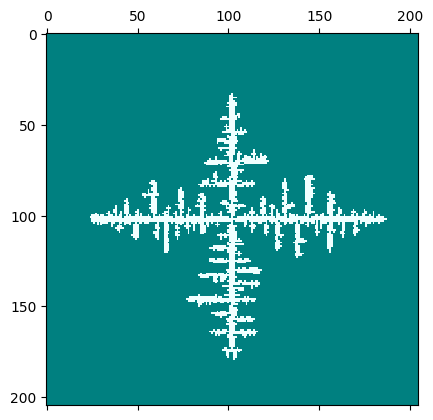

CPU times: user 1min 7s, sys: 401 ms, total: 1min 7s
Wall time: 1min 7s


In [ ]:
%%time
r = 100
M = 36
mass, matrix = DLAcluster(r, M)
plt.matshow(matrix, fignum=None, interpolation='nearest', cmap=colors.ListedColormap(['teal','azure', 'teal']))
plt.savefig("/content/gdrive/MyDrive/5SEM/SIM/images/cluster_r_{}_M_{}.png".format(r, M), dpi=200)
plt.show()